# Lab1

In [3]:
from IPython.core.display import display, HTML
%load_ext autoreload
%autoreload 2
display(HTML("<style>.container { width:100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Library Importation

In [4]:
import pandas as pd
from kernel import *
from model import GaussianProcess
from visualization import visualize_ax
from utils import transform_time_hour
import matplotlib.pyplot as plt
import numpy as np

# Data Loading

In [5]:
data = pd.read_csv('data/sotonmet.txt', sep=",")

In [6]:
data.head()

,Update Date and Time (ISO),Update Duration (ms),Reading Date and Time (ISO),Air pressure (mb),Air temperature (C),Tide height (m),Wind direction (deg),Wind gust speed (kn),Wind speed (kn),True air temperature (C),True tide height (m),Independent tide height prediction (m),Independent tide height deviation (m),Dependent tide height prediction (m),Dependent tide height deviation (m),Independent air temperature prediction (C),Independent air temperature deviation (C),Dependent air temperature prediction (C),Dependent air temperature deviation (C)
0,2007-05-26T12:05:00,0,2007-05-26T12:05:00,NaN,NaN,NaN,NaN,NaN,NaN,16.92,2.30,2.4007,0.039110,2.3715,0.036670,17.2348,0.23222,17.2339,0.23187
1,2007-05-26T12:10:00,0,2007-05-26T12:10:00,1006.0,16.7,2.3,22.0,12.0,12.4,16.42,2.24,2.4016,0.058707,2.3365,0.045564,17.1932,0.29931,17.1848,0.29732
2,2007-05-26T12:15:00,0,2007-05-26T12:15:00,1006.0,16.0,2.2,13.0,18.1,13.2,16.00,2.19,2.2945,0.037006,2.2836,0.029853,16.8005,0.25186,16.8130,0.24920
3,2007-05-26T12:20:00,0,2007-05-26T12:20:00,1006.0,15.9,2.1,16.0,14.2,13.0,15.92,2.14,2.1455,0.021627,2.1553,0.019945,16.0734,0.17207,16.0621,0.17101
4,2007-05-26T12:25:00,0,2007-05-26T12:25:00,1005.0,16.1,2.1,12.0,14.4,12.0,16.08,2.09,2.0900,0.028609,2.1115,0.023468,15.8401,0.21507,15.8126,0.21158


In [7]:
# Get Data
y = data["Tide height (m)"]
y_norm = y - np.mean(y)

# Ground Truth
y_true = data["True tide height (m)"]
y_true_norm = y_true - np.mean(y_true)


# Reading Time
t = transform_time_hour(data["Reading Date and Time (ISO)"])

# training / missing data

t_train = t[~data["Tide height (m)"].isnull()]
t_test = np.linspace(-10, 150, 1600)
t_test_true = t[data["Tide height (m)"].isnull()]

y_train = y_norm[~data["Tide height (m)"].isnull()]
y_test_true = y_true_norm[data["Tide height (m)"].isnull()]

Text(0.5, 0, 'Time (Hour)')

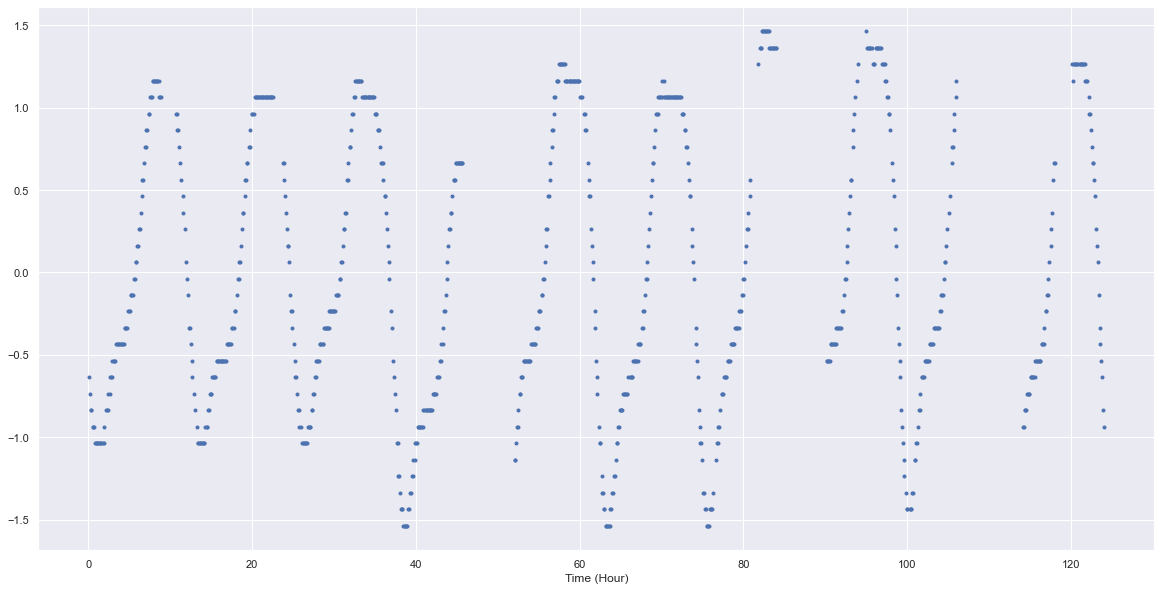

In [8]:
## Plot the data
plt.figure(figsize=(20,10))
plt.plot(t, y_norm, ".")
plt.xlabel("Time (Hour)")

## Test Different Kernels

### RBF Kernel

Computing noise: 0.01
Fixing parameters...
-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 82.86432306340112
Value Parameters: [0.15477863 0.58810251 0.01      ]
Computing noise: 0.1
Fixing parameters...
The following parameters failed: [1.75798001 0.91927769 0.1       ]
SVD did not converge
The following parameters failed: [1.75798001 0.91927769 0.1       ]
SVD did not converge
-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 958.0622384306064
Value Parameters: [1.75798    0.91927769 0.1       ]
Computing noise: 0.3
Fixing parameters...
-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 84.66201181958775
Value Parameters: [1.80040672 0.89448292 0.3       ]
Computing noise: 1.0
Fixing parameters...
-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: -928.1494495105462
Value Parameters: [2.61796334 0.91288152 1.        ]


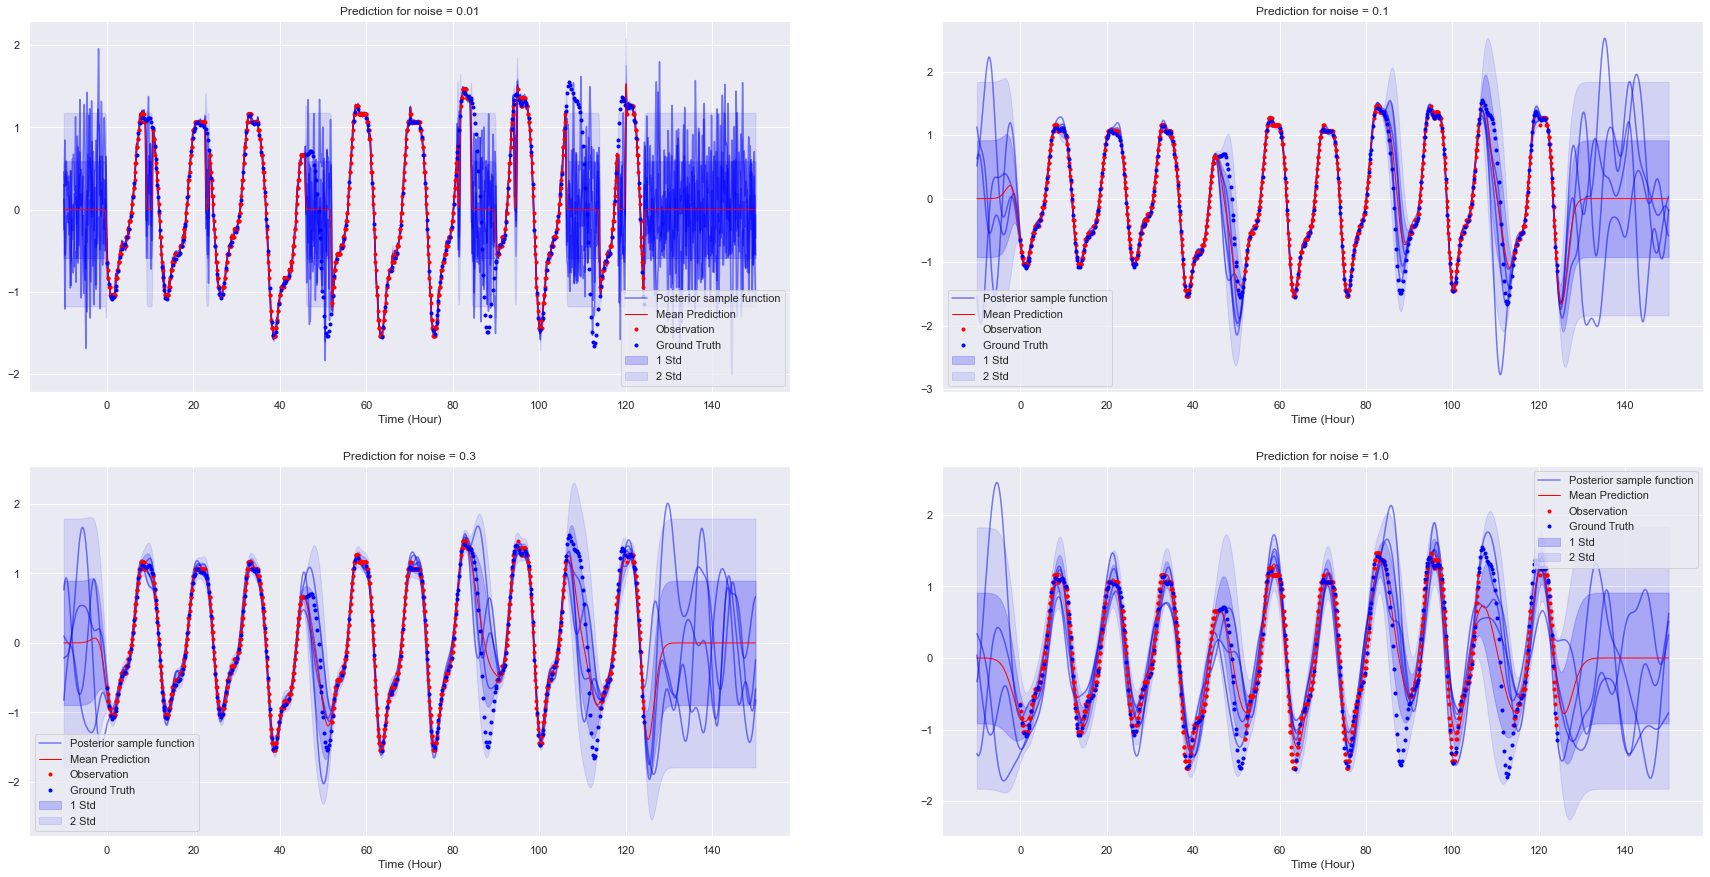

In [73]:
## Try noise levels : [0.01, 0.1, 0.3, 1.] ~ 3 minutes
noise_list = [0.01, 0.1, 0.3, 1.]
f, axs = plt.subplots(2,2, figsize=(30,15))
kernel = RBF(1.)

for i, noise in enumerate(noise_list):
    print("Computing noise:", noise)
    model = GaussianProcess(kernel, noise = noise)
    model.fit(t_train, y_train)
    model.optimize_log(bounds = [(0.01,100.), (0.01,100.), None ])
    result = model.predict(t_test)
    axs[i // 2, i % 2] = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title('Prediction for noise = {}'.format(noise))


-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1574.3687501862046
Value Parameters: [1.47130563 0.80885011 0.02931459]


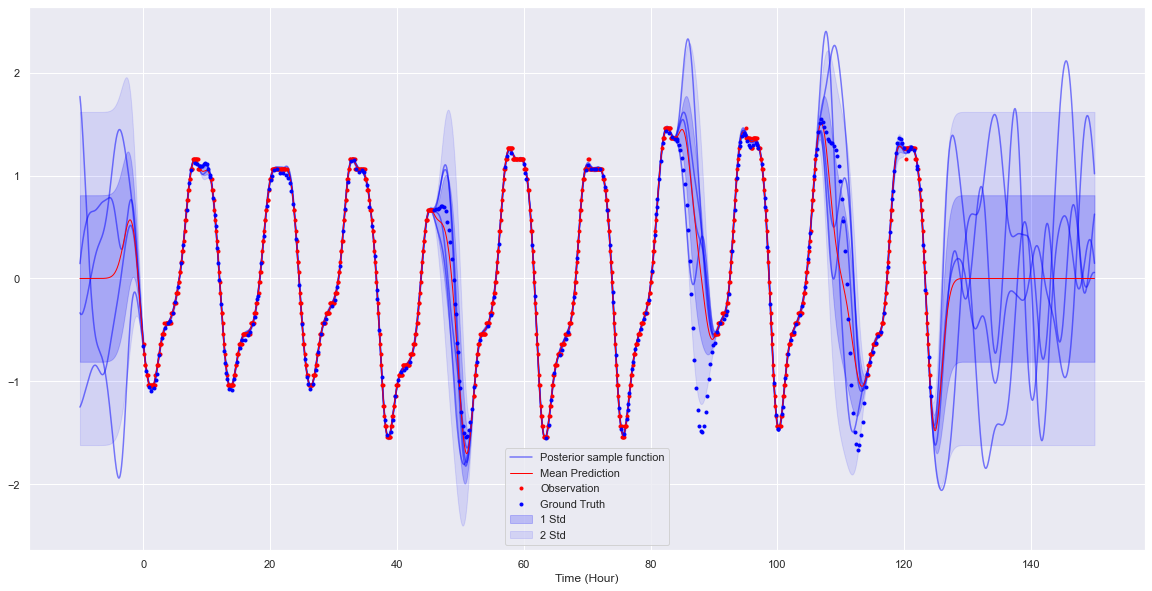

In [76]:
## Optimize over noise
f, ax = plt.subplots(figsize=(20,10))

kernel = RBF(1.)
model = GaussianProcess(kernel, noise = 0.1)
model.fit(t_train, y_train)
model.optimize_log()

result = model.predict(t_test)

ax = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, ax)

### Periodic Kernel

In [78]:
## Apply Gaussian Process Prediction

kernel = Periodic(1., 25.)
model = GaussianProcess(kernel, noise = 0.03)
model.fit(t_train, y_train)
model.optimize_log()

result = model.predict(t_test)

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 367.6835006575884
Value Parameters: [ 0.45149179 24.70099541  0.85386977  0.15262756]


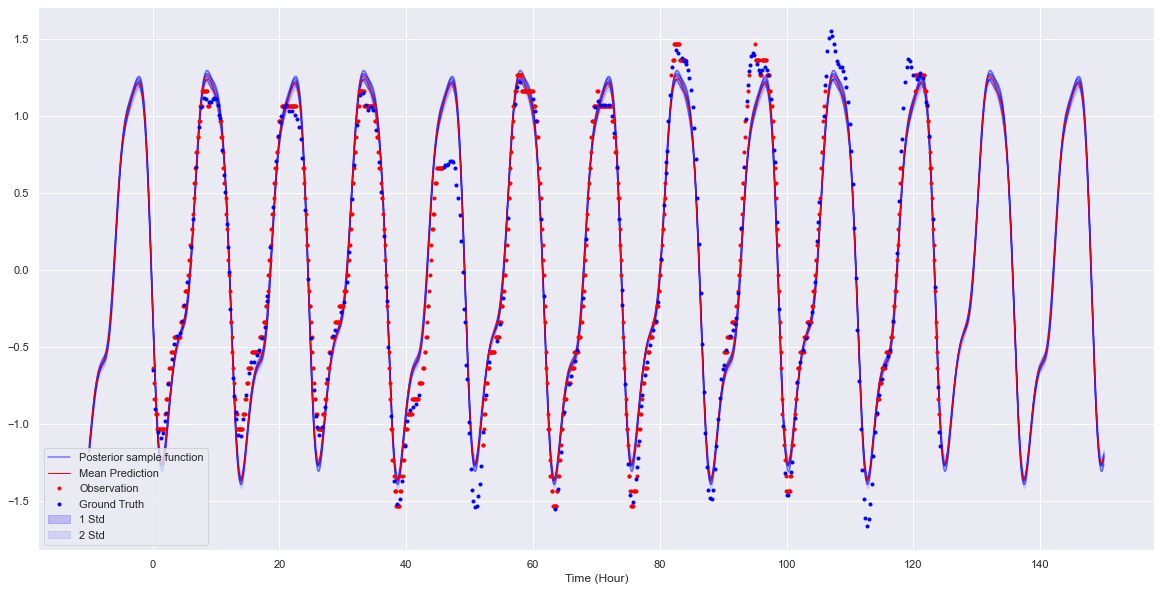

In [82]:
f, ax = plt.subplots(figsize=(20,10))
ax = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, ax)

### Periodic + RBF Kernel

In [83]:
## Apply Gaussian Process Prediction

kernel = Add_Kernel(RBF(), Periodic(1., 25.))
model = GaussianProcess(kernel, noise = 0.03)
model.fit(t_train, y_train)
model.optimize_log()

result = model.predict(t_test)

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1653.6863883760784
Value Parameters: [ 1.19820514  0.17624702  0.3521879  24.70655223  0.71706403  0.02885915]


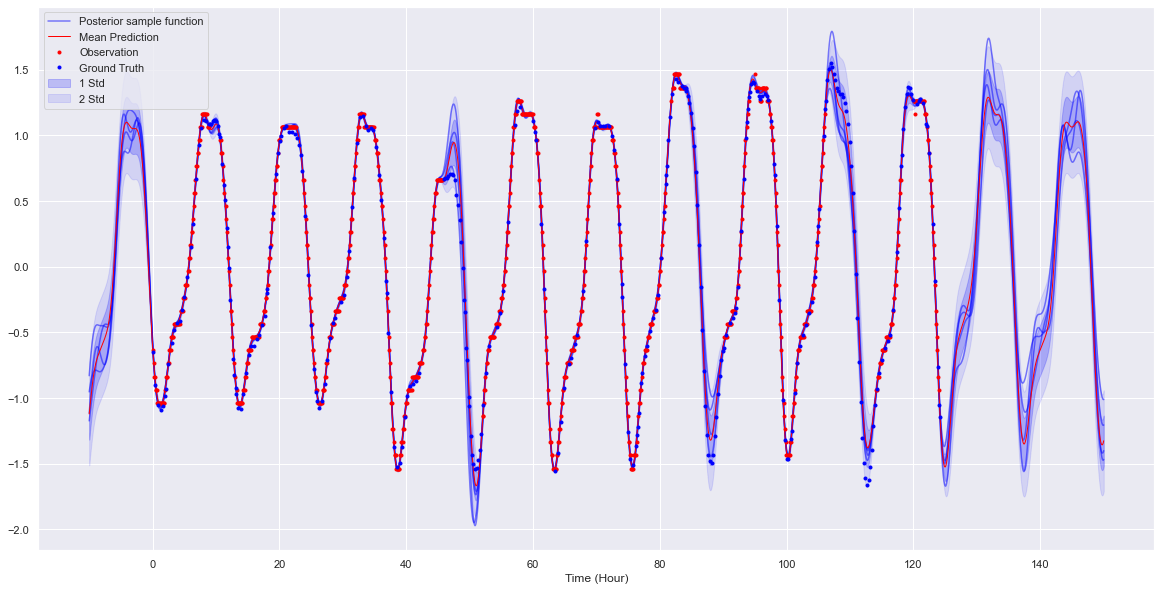

In [84]:
f, ax = plt.subplots(figsize=(20,10))
ax = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, ax)

### Periodic x RBF Kernel

In [85]:
## Apply Gaussian Process Prediction

kernel = Multiply_Kernel(RBF(), Periodic(1., 25.))
model = GaussianProcess(kernel, noise = 0.03)
model.fit(t_train, y_train)
model.optimize_log()

result = model.predict(t_test)

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1588.2314182132452
Value Parameters: [3.39552616 1.08623538 4.4979785  5.29741697 1.08510521 0.02901552]


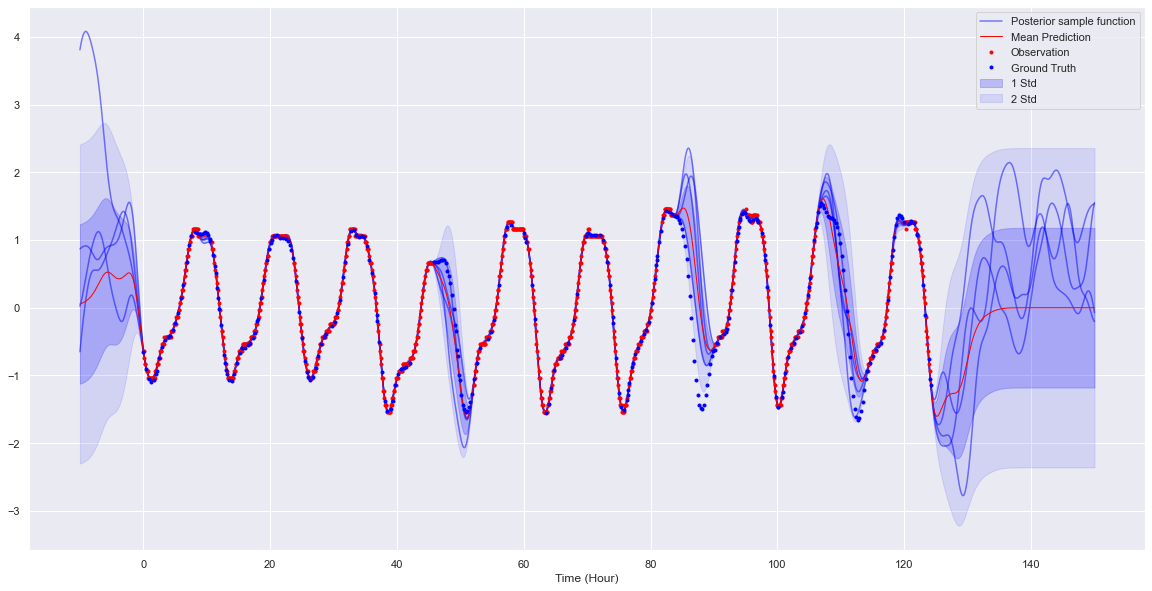

In [86]:
f, ax = plt.subplots(figsize=(20,10))
ax = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, ax)

### Periodic x RBF + Periodic + RBF Kernel

In [88]:
## Apply Gaussian Process Prediction

kernel = Add_Kernel(Multiply_Kernel(RBF(), Periodic(1., 25.)), Add_Kernel(RBF(), Periodic(1., 25.)))
model = GaussianProcess(kernel, noise = 0.03)
model.fit(t_train, y_train)
model.optimize_log()

result = model.predict(t_test)

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1662.6682922508803
Value Parameters: [ 0.95104525  0.30665269  0.82180129 19.43150799  0.30664359  3.50413349
  0.18872891  0.43585825 24.74632846  0.85460921  0.02860065]


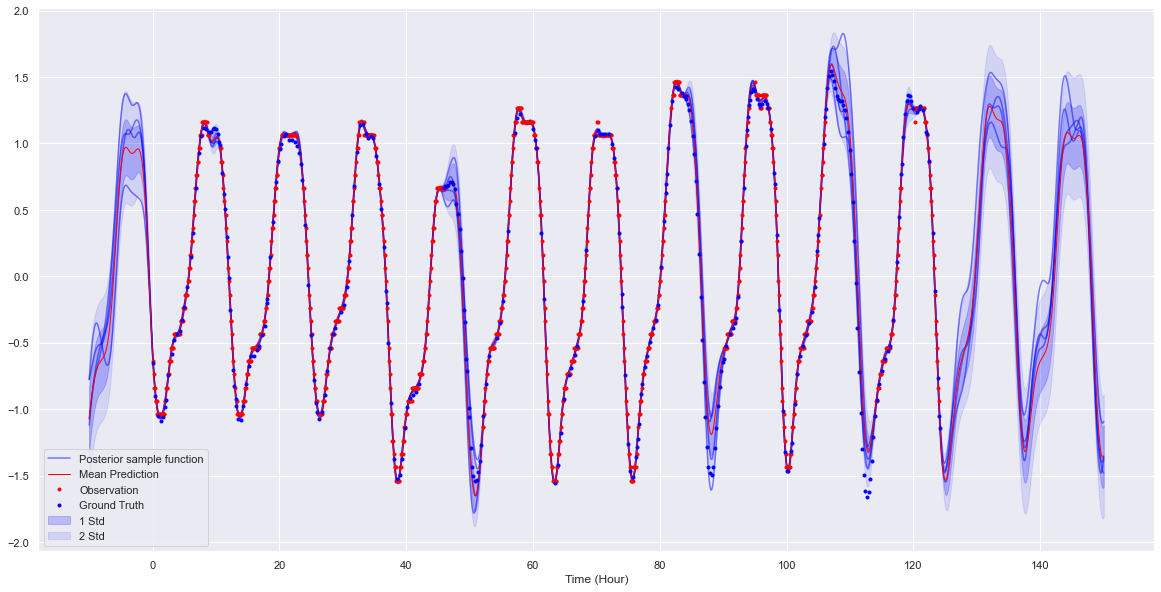

In [89]:
f, ax = plt.subplots(figsize=(20,10))
ax = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, ax)

### Sequential

In [40]:
kernel = RBF()
model = GaussianProcess(kernel, noise = 0.03)
t_test_sequential, mean_prediction_sequential, var_prediction_sequential = model.sequential_prediction(t_train, y_train)

100%|████████████████████████████████████████████████████████████████████████████████| 915/915 [00:54<00:00, 16.74it/s]


In [ ]:
f, ax = plt.subplots(figsize=(20,10))
ax = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test_sequential, [mean_prediction_sequential, var_prediction_sequential], ax)